In [1]:
# Environment Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from captum.attr import IntegratedGradients, Occlusion
import warnings
import re
from glob import glob
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings('ignore')

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [2]:
# Load preprocessed data
# This assumes you have already run the feature extraction pipeline
# and saved the results in myData.npz
import os
if os.path.isfile("myData.npz"):
    print("✅ Loading preprocessed features...")
    with np.load("myData.npz") as data:
        myData = data['myData']       # Mel spectrograms (N, 128, 256, 1)
        myData2 = data['myData2']     # Topological features (N, 64, 64, 6)
        myY = data['myY']             # One-hot labels (N, 6)
        myActors = data['myActors']   # Actor IDs
        myDatasets = data['myDatasets']  # Dataset names

    print(f"Mel spectrograms shape: {myData.shape}")
    print(f"Topological features shape: {myData2.shape}")
    print(f"Labels shape: {myY.shape}")
    print(f"Number of unique actors: {len(np.unique(myActors))}")
    print(f"Number of unique datasets: {len(np.unique(myDatasets))}")
else:
    folder = './savefiles2'

    def findFilesFromPattern(pattern):
        pattern = re.compile(pattern + r'_(.*?)_(.*?)_(.*?)_(\d+)_(\d+)\.npy')
        heatmaps_dict = {}

        for filename in os.listdir(folder):
            match = pattern.match(filename)
            if match:
                dataset, actor, emotion, i, j = map(str, match.groups())
                i, j = int(i), int(j)
                filepath = os.path.join(folder, filename)
                data = np.load(filepath)

                heatmaps_dict[f'{dataset}_{actor}_{emotion}_{j // 2}_{j%2}'] = {'data': data, 'dataset': dataset, 'actor': actor, 'emotion':emotion, 'type': j}

        return heatmaps_dict

    mfccwasserstein = findFilesFromPattern('wassersteinMfccHeat')
    melwasserstein = findFilesFromPattern('wassersteinHeat')
    meltimeeuclid = findFilesFromPattern('timeMetricHeat')
    meleuclid = findFilesFromPattern('euclideanHeat')

    def load_spectrograms(prefixes, path='./savefiles'):
        patterns = []
        for prefix in prefixes:
            patterns.append(os.path.join(path, f"{prefix}_*.npy"))
        my_globs = glob(patterns[0])
        for pattern in patterns[1:]:
            my_globs = my_globs + glob(pattern)
        file_list = sorted(my_globs)
        return [np.load(file) for i, file in enumerate(file_list)]

    myRaw = load_spectrograms(["savee", 'tess', 'radvess', 'cremad'])
    print(len(mfccwasserstein))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 1]))
    print(np.array([[meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] == 0]]).shape)

    print(len(myRaw))

    myData = np.array([myRaw])
    print('finish data')
    myData = myData.astype('float32')
    myData = np.transpose(myData, (1, 2, 3, 0))
    myEmotionMap = {
        'neutral': 1, 'happy':2, 'sad':3, 'angry':4, 'fearful':5, 'disgust':6, 'calm':7, 'surprised':8
    }
    myY = np.array(
        [myEmotionMap[mfccwasserstein[key]['emotion']] -1 for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    myActors = np.array(
        [mfccwasserstein[key]['actor'] + '_' + mfccwasserstein[key]['dataset']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    myDatasets = np.array(
        [mfccwasserstein[key]['dataset']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    print(np.unique(myActors))

    print(np.unique(myY))

    myY = to_categorical(myY, num_classes=6)

    myData2 = np.array([
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0],
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 1],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 0],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 1],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 1]
                        ])
    print('finish data')
    myData2 = myData2.astype('float32')
    print(myData2.shape)
    myData2 = np.transpose(myData2, (1, 2, 3, 0))
    print(myData2.shape)
    np.savez_compressed(
        "myData.npz",
        myData=myData,
        myData2=myData2,
        myY=myY,
        myActors=myActors,
        myDatasets=myDatasets,
    )

✅ Loading preprocessed features...
Mel spectrograms shape: (11318, 128, 256, 1)
Topological features shape: (11318, 32, 32, 6)
Labels shape: (11318, 6)
Number of unique actors: 121
Number of unique datasets: 4


Generating topological feature visualizations...


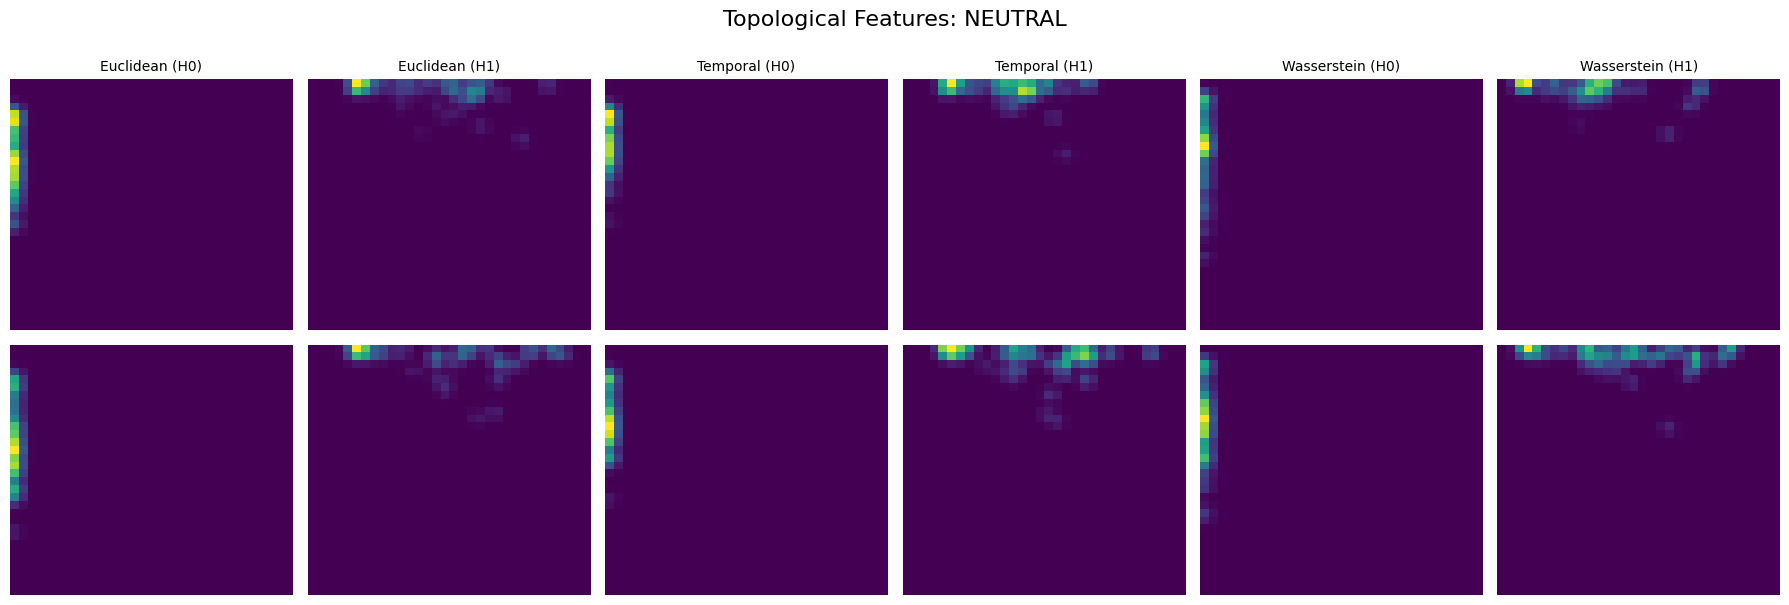

Saved: topology_neutral.png



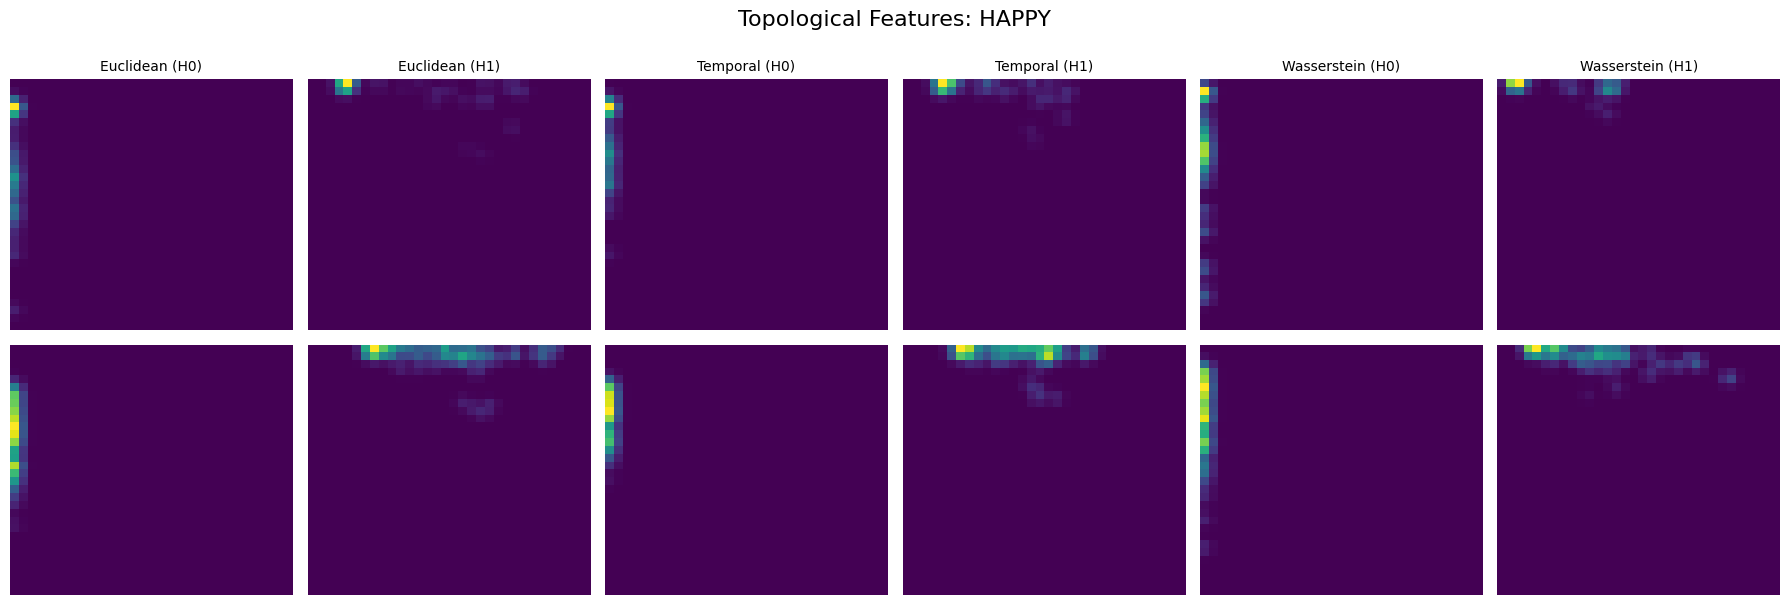

Saved: topology_happy.png



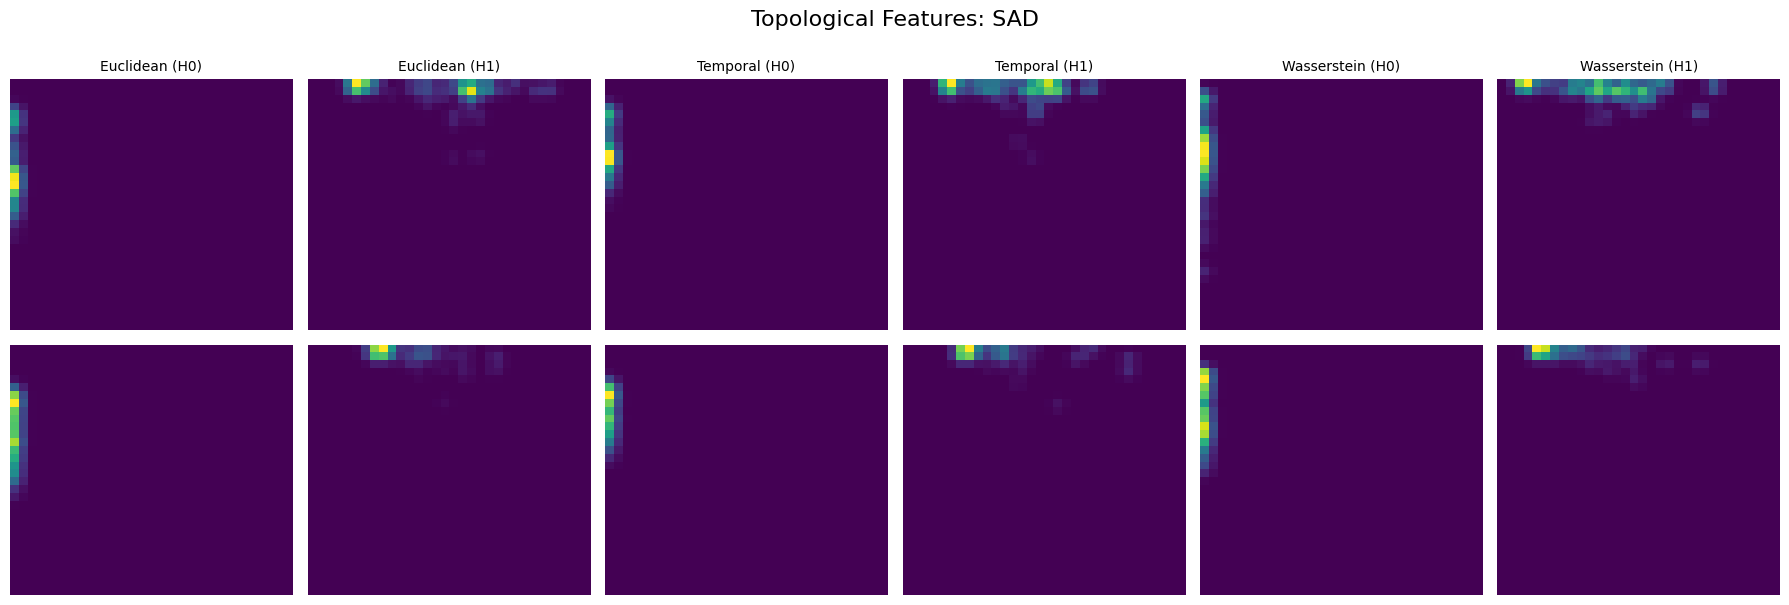

Saved: topology_sad.png



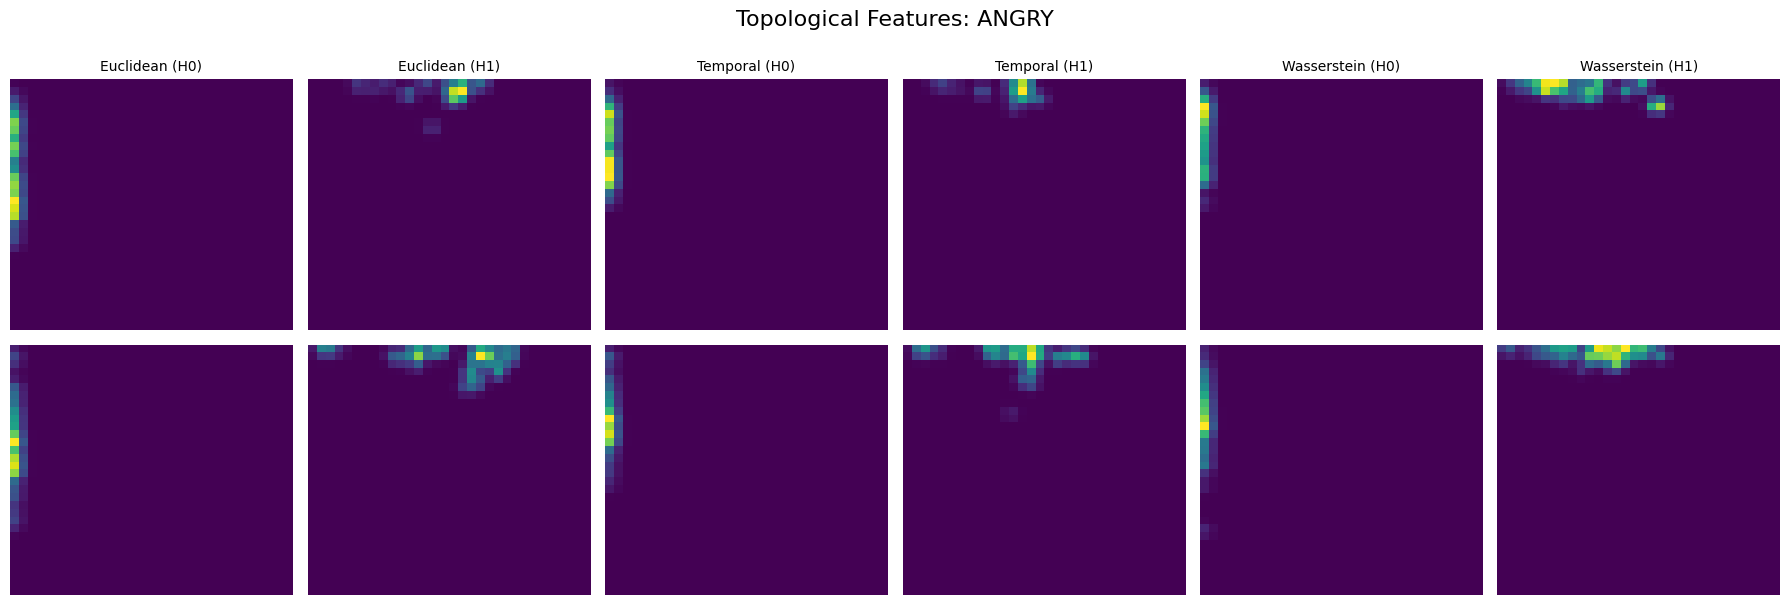

Saved: topology_angry.png



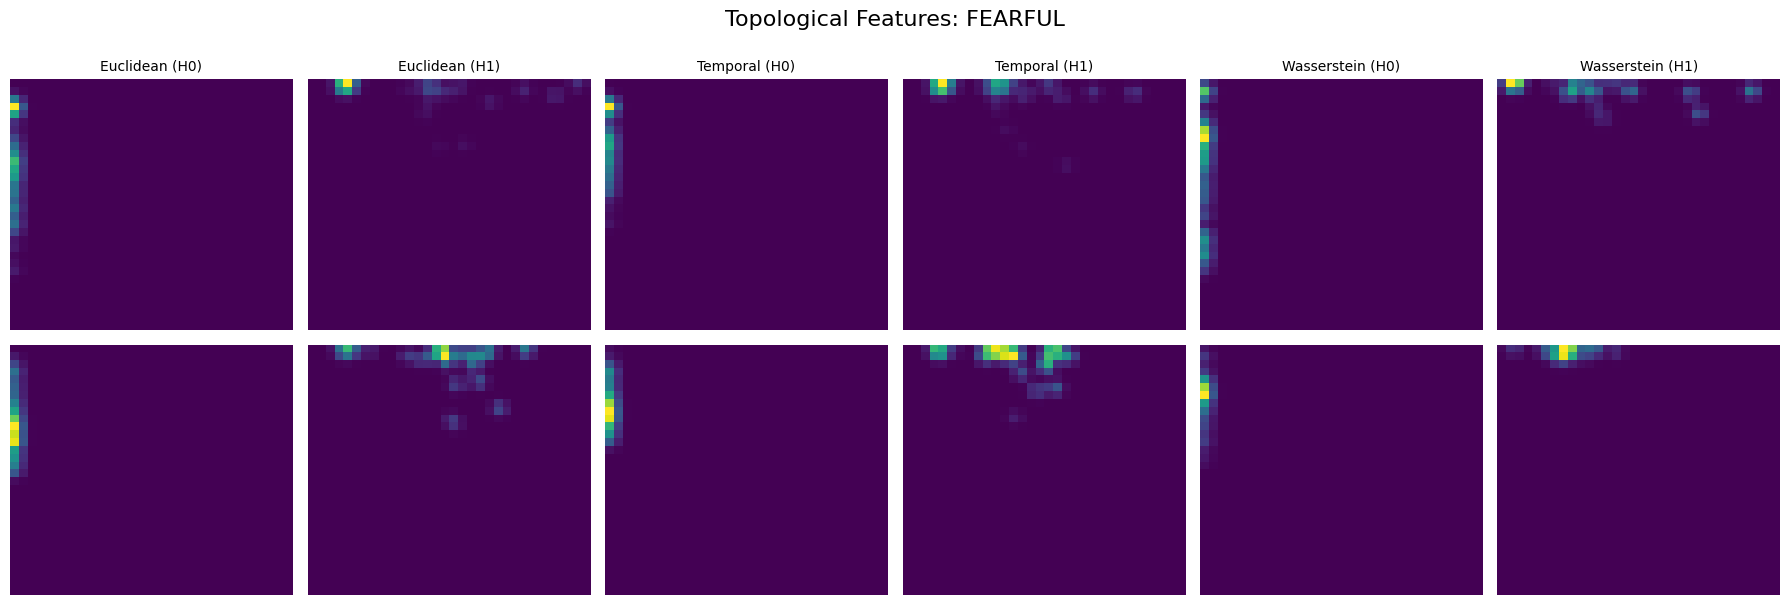

Saved: topology_fearful.png



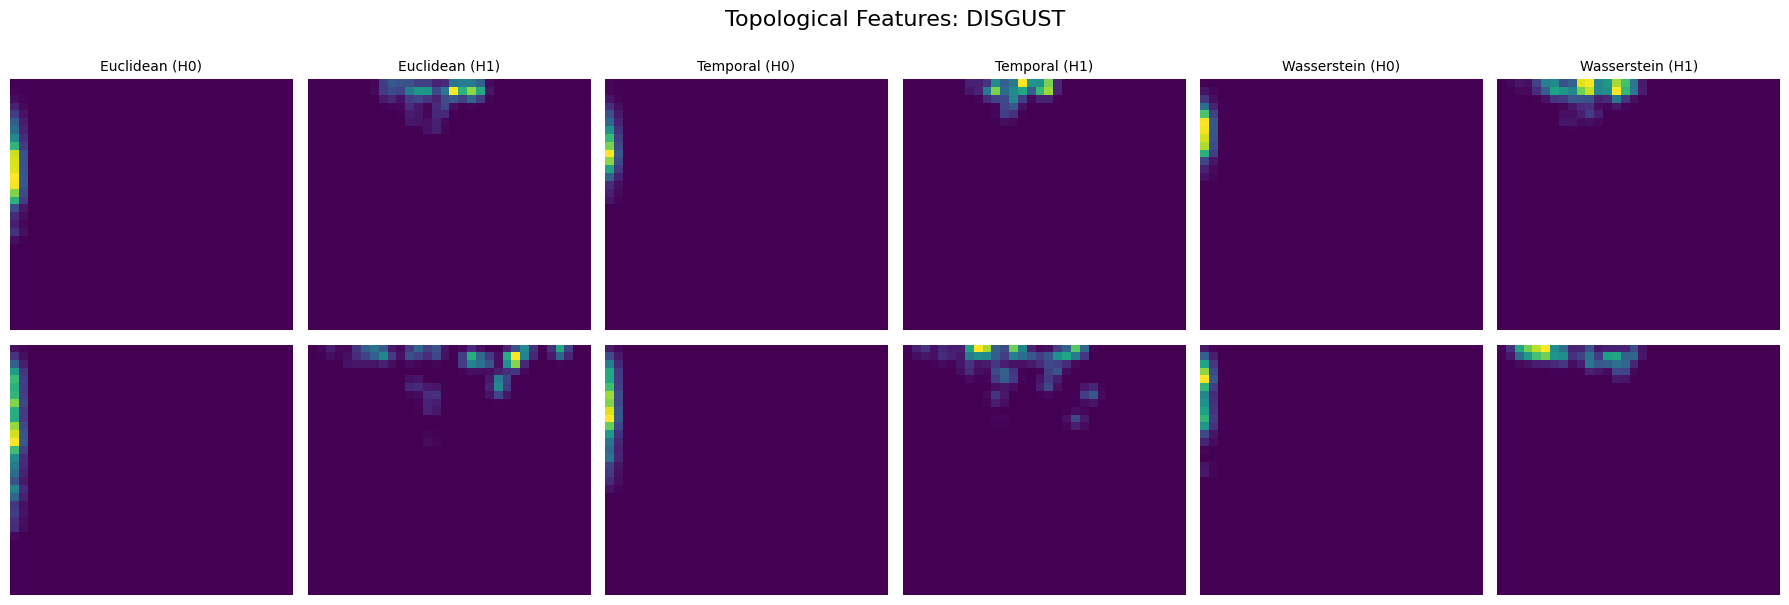

Saved: topology_disgust.png



In [3]:
# Visualize example topological features for each emotion
def visualize_topological_channels(data, labels, actors, num_samples=3):
    """
    Visualize topological channels for each emotion class.
    """
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    channel_names = [
        'Euclidean (H0)',
        'Euclidean (H1)',
        'Temporal (H0)',
        'Temporal (H1)',
        'Wasserstein (H0)',
        'Wasserstein (H1)'
    ]

    label_ids = np.argmax(labels, axis=1)

    for emotion_id in range(6):
        emotion_mask = label_ids == emotion_id
        emotion_samples = data[emotion_mask]

        # Select random samples
        indices = np.random.choice(len(emotion_samples), min(num_samples, len(emotion_samples)), replace=False)

        fig, axes = plt.subplots(num_samples, 6, figsize=(18, 3*num_samples))
        fig.suptitle(f'Topological Features: {emotions[emotion_id].upper()}', fontsize=16, y=1.00)

        for row, idx in enumerate(indices):
            sample = emotion_samples[idx]  # Shape: (H, W, 6)
            for col in range(6):
                ax = axes[row, col] if num_samples > 1 else axes[col]
                ax.imshow(sample[:, :, col], cmap='viridis', aspect='auto')
                if row == 0:
                    ax.set_title(channel_names[col], fontsize=10)
                ax.axis('off')

        plt.tight_layout()
        plt.savefig(f'topology_{emotions[emotion_id]}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: topology_{emotions[emotion_id]}.png\n")

# Visualize topological features
if 'myData2' in locals():
    print("Generating topological feature visualizations...")
    visualize_topological_channels(myData2, myY, myActors, num_samples=2)

In [ ]:
# Model 1: Mel Spectrogram CNN
class MelSpectrogramCNN(nn.Module):
    """Baseline CNN for mel spectrograms."""
    def __init__(self, num_classes=6):
        super(MelSpectrogramCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Model 2: Topological Feature CNN with Embedding Output
class TopologicalCNN(nn.Module):
    """CNN for 6-channel topological features with optional embedding return."""
    def __init__(self, num_classes=6):
        super(TopologicalCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, return_embedding=False):
        f = self.features(x)
        z = self.classifier[:-1](f)  # 64-dim embedding
        logits = self.classifier[-1](z)
        return z if return_embedding else logits


# Model 3: Combined Fusion Model
class CombinedFusionModel(nn.Module):
    """Late fusion of mel spectrogram and topological features."""
    def __init__(self, num_classes=6):
        super(CombinedFusionModel, self).__init__()
        # Mel branch
        self.mel_branch = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Topological branch
        self.topo_branch = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, mel_input, topo_input):
        mel_emb = self.mel_branch(mel_input)
        topo_emb = self.topo_branch(topo_input)
        combined = torch.cat([mel_emb, topo_emb], dim=1)
        return self.classifier(combined)

print("✅ Model architectures defined")

✅ Model architectures defined


In [5]:
# Define stratified split function
def stratified_group_split_3way(y, z, groups, val_size=0.2, test_size=0.2, random_state=42):
    """3-way stratified split respecting group boundaries."""
    from sklearn.model_selection import StratifiedShuffleSplit

    rng = np.random.default_rng(random_state)
    df = pd.DataFrame({'y': y, 'z': z, 'group': groups})
    df["strat_label"] = df["y"].astype(str) + "_" + df["z"].astype(str)

    group_labels = (
        df.groupby('group')['y']
          .agg(lambda s: s.value_counts().index[0])
          .reset_index()
    )

    sss_outer = StratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )
    sss_inner = StratifiedShuffleSplit(
        n_splits=1, test_size=val_size/(1 - test_size), random_state=random_state + 1
    )

    group_indices = np.arange(len(group_labels))
    for trainval_g, test_g in sss_outer.split(group_indices, group_labels['y']):
        trainval_groups = group_labels['group'].iloc[trainval_g].values
        test_groups = group_labels['group'].iloc[test_g].values

        trainval_df = group_labels.iloc[trainval_g]
        trainval_idx = np.arange(len(trainval_df))

        for train_g, val_g in sss_inner.split(trainval_idx, trainval_df['y']):
            train_groups = trainval_df['group'].iloc[train_g].values
            val_groups = trainval_df['group'].iloc[val_g].values

    train_mask = df['group'].isin(train_groups)
    val_mask = df['group'].isin(val_groups)
    test_mask = df['group'].isin(test_groups)

    train_idx = np.where(train_mask)[0]
    val_idx = np.where(val_mask)[0]
    test_idx = np.where(test_mask)[0]

    return train_idx, val_idx, test_idx


# Perform split
if 'myY' in locals():
    groups = myActors
    train_idx, val_idx, test_idx = stratified_group_split_3way(
        y=np.argmax(myY, axis=1),
        z=myDatasets,
        groups=groups,
        val_size=0.2,
        test_size=0.2
    )

    print(f"Train speakers: {len(np.unique(myActors[train_idx]))}")
    print(f"Val speakers: {len(np.unique(myActors[val_idx]))}")
    print(f"Test speakers: {len(np.unique(myActors[test_idx]))}")
    print(f"\nTrain samples: {len(train_idx)}")
    print(f"Val samples: {len(val_idx)}")
    print(f"Test samples: {len(test_idx)}")

    # Filter for non-noisy test samples (clean evaluation)
    X_train, X_val, X_test = myData[train_idx], myData[val_idx], myData[test_idx]
    X_train2, X_val2, X_test2 = myData2[train_idx], myData2[val_idx], myData2[test_idx]
    y_train, y_val, y_test = myY[train_idx], myY[val_idx], myY[test_idx]

    # Convert to PyTorch tensors
    # Filter by noise for training (include both clean and noisy)
    X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_train2_tensor = torch.tensor(X_train2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

    X_val_tensor = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_val2_tensor = torch.tensor(X_val2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_val_tensor = torch.tensor(np.argmax(y_val, axis=1), dtype=torch.long)

    # Test: only clean samples
    X_test_tensor = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_test2_tensor = torch.tensor(X_test2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

    print(f"\nTensor shapes:")
    print(f"Train mel: {X_train_tensor.shape}")
    print(f"Train topo: {X_train2_tensor.shape}")
    print(f"Test mel: {X_test_tensor.shape}")
    print(f"Test topo: {X_test2_tensor.shape}")

Train speakers: 72
Val speakers: 24
Test speakers: 25

Train samples: 7836
Val samples: 1751
Test samples: 1731

Tensor shapes:
Train mel: torch.Size([7836, 1, 128, 256])
Train topo: torch.Size([7836, 6, 32, 32])
Test mel: torch.Size([1731, 1, 128, 256])
Test topo: torch.Size([1731, 6, 32, 32])


In [6]:
def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3,
                model_name="model", device=device):
    """
    Generic training function with validation.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
    top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            if len(batch) == 3:  # Combined model
                X_batch, X2_batch, y_batch = batch
                X_batch, X2_batch, y_batch = X_batch.to(device), X2_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch, X2_batch)
            else:  # Single input model
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    X_val, X2_val, y_val = batch
                    X_val, X2_val, y_val = X_val.to(device), X2_val.to(device), y_val.to(device)
                    outputs = model(X_val, X2_val)
                else:
                    X_val, y_val = batch
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    outputs = model(X_val)

                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                preds = torch.softmax(outputs, dim=1)
                val_preds.append(preds)
                val_labels.append(y_val)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_auc = auroc(val_preds, val_labels).item()
        val_top3 = top3acc(val_preds, val_labels).item()
        y_pred = torch.argmax(val_preds, dim=1)
        accuracy = (y_pred == val_labels).float().mean().item()

        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_auc'].append(val_auc)
        history['val_acc'].append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"train_loss: {train_loss/len(train_loader):.4f} - "
              f"val_loss: {val_loss/len(val_loader):.4f} - "
              f"val_auc: {val_auc:.4f} - "
              f"val_top3: {val_top3:.4f} - "
              f"val_acc: {accuracy:.4f}")

        # Save best model
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print(f"✅ Saved best model: {accuracy:.4f}")

    return model, history


def evaluate_model(model, test_loader, model_path, device=device):
    """
    Evaluate model on test set.
    """
    model.load_state_dict(torch.load(model_path))
    model.eval()

    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
    top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 3:
                X_batch, X2_batch, y_batch = batch
                X_batch, X2_batch = X_batch.to(device), X2_batch.to(device)
                outputs = model(X_batch, X2_batch)
            else:
                X_batch, y_batch = batch
                X_batch = X_batch.to(device)
                outputs = model(X_batch)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
            all_probs.append(probs)

    all_probs = torch.cat(all_probs)
    all_labels_tensor = torch.tensor(all_labels).to(device)

    test_auc = auroc(all_probs, all_labels_tensor).item()
    test_top3 = top3acc(all_probs, all_labels_tensor).item()
    test_acc = (torch.argmax(all_probs, dim=1) == all_labels_tensor).float().mean().item()

    print(f"\nTest Results:")
    print(f"AUC: {test_auc:.4f}")
    print(f"Top-3 Accuracy: {test_top3:.4f}")
    print(f"Accuracy: {test_acc:.4f}")

    # Classification report
    class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    report = classification_report(all_labels, all_preds, target_names=class_labels)
    print("\nClassification Report:")
    print(report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return {
        'auc': test_auc,
        'top3_acc': test_top3,
        'acc': test_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'report': report
    }

print("✅ Training functions defined")

✅ Training functions defined


### 4.3 Train Baseline Model (Mel Spectrogram)

---

Training Mel Spectrogram Baseline...

Epoch 1/40 - train_loss: 1.6285 - val_loss: 1.7777 - val_auc: 0.6735 - val_top3: 0.5429 - val_acc: 0.1890
✅ Saved best model: 0.1890
Epoch 2/40 - train_loss: 1.1702 - val_loss: 1.4910 - val_auc: 0.7606 - val_top3: 0.7868 - val_acc: 0.3912
✅ Saved best model: 0.3912
Epoch 3/40 - train_loss: 0.9717 - val_loss: 2.5922 - val_auc: 0.7335 - val_top3: 0.6366 - val_acc: 0.2633
Epoch 4/40 - train_loss: 0.8855 - val_loss: 2.2654 - val_auc: 0.7550 - val_top3: 0.6696 - val_acc: 0.3118
Epoch 5/40 - train_loss: 0.8320 - val_loss: 2.1735 - val_auc: 0.7513 - val_top3: 0.7267 - val_acc: 0.3038
Epoch 6/40 - train_loss: 0.8039 - val_loss: 1.3683 - val_auc: 0.8262 - val_top3: 0.8514 - val_acc: 0.4991
✅ Saved best model: 0.4991
Epoch 7/40 - train_loss: 0.7563 - val_loss: 1.3617 - val_auc: 0.8262 - val_top3: 0.8376 - val_acc: 0.4803
Epoch 8/40 - train_loss: 0.7137 - val_loss: 1.6326 - val_auc: 0.8110 - val_top3: 0.7760 - val_acc: 0.4363
Epoch 9/40 - train_loss: 0.6854 -

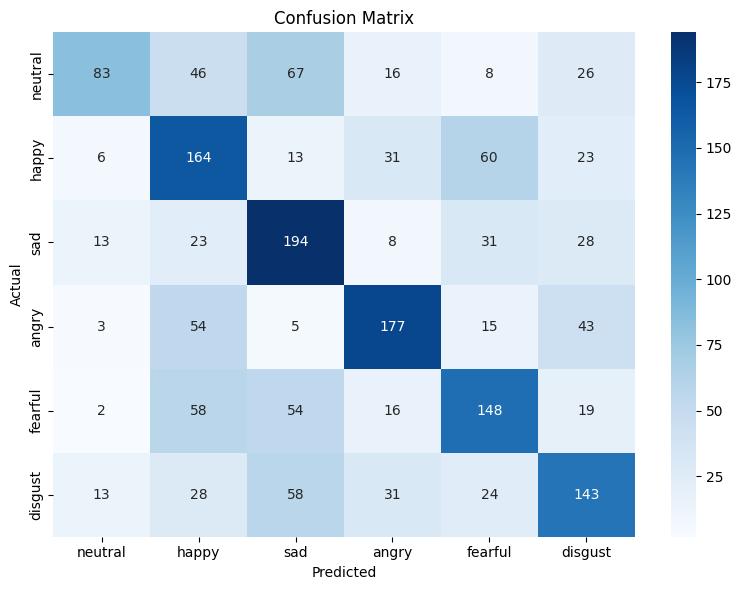

In [7]:
# Create data loaders for mel spectrogram
if 'X_train_tensor' in locals():
    train_dataset_mel = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset_mel = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset_mel = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader_mel = DataLoader(train_dataset_mel, batch_size=256, shuffle=True,
                                   num_workers=4, pin_memory=True)
    val_loader_mel = DataLoader(val_dataset_mel, batch_size=256,
                                 num_workers=4, pin_memory=True)
    test_loader_mel = DataLoader(test_dataset_mel, batch_size=256)

    # Train mel spectrogram baseline
    print("Training Mel Spectrogram Baseline...\n")
    model_mel = MelSpectrogramCNN().to(device)
    model_mel, history_mel = train_model(
        model_mel, train_loader_mel, val_loader_mel,
        num_epochs=40, model_name="model_mel", device=device
    )

    # Evaluate
    print("\n" + "="*60)
    print("Mel Spectrogram Baseline Evaluation")
    print("="*60)
    results_mel = evaluate_model(model_mel, test_loader_mel, "best_model_mel.pth", device)

Training Topological Feature Model...



Epoch 1/40 - train_loss: 1.7347 - val_loss: 1.7119 - val_auc: 0.6595 - val_top3: 0.6530 - val_acc: 0.2667
✅ Saved best model: 0.2667
Epoch 2/40 - train_loss: 1.5827 - val_loss: 1.5891 - val_auc: 0.6959 - val_top3: 0.7302 - val_acc: 0.3101
✅ Saved best model: 0.3101
Epoch 3/40 - train_loss: 1.4619 - val_loss: 1.7060 - val_auc: 0.7042 - val_top3: 0.6903 - val_acc: 0.3033
Epoch 4/40 - train_loss: 1.3925 - val_loss: 1.6896 - val_auc: 0.7003 - val_top3: 0.6737 - val_acc: 0.2519
Epoch 5/40 - train_loss: 1.3307 - val_loss: 1.5624 - val_auc: 0.7179 - val_top3: 0.7564 - val_acc: 0.3352
✅ Saved best model: 0.3352
Epoch 6/40 - train_loss: 1.2802 - val_loss: 1.5484 - val_auc: 0.7281 - val_top3: 0.7656 - val_acc: 0.3644
✅ Saved best model: 0.3644
Epoch 7/40 - train_loss: 1.2533 - val_loss: 1.5771 - val_auc: 0.7301 - val_top3: 0.7568 - val_acc: 0.3495
Epoch 8/40 - train_loss: 1.2194 - val_loss: 1.5861 - val_auc: 0.7291 - val_top3: 0.7711 - val_acc: 0.3626
Epoch 9/40 - train_loss: 1.2012 - val_loss: 

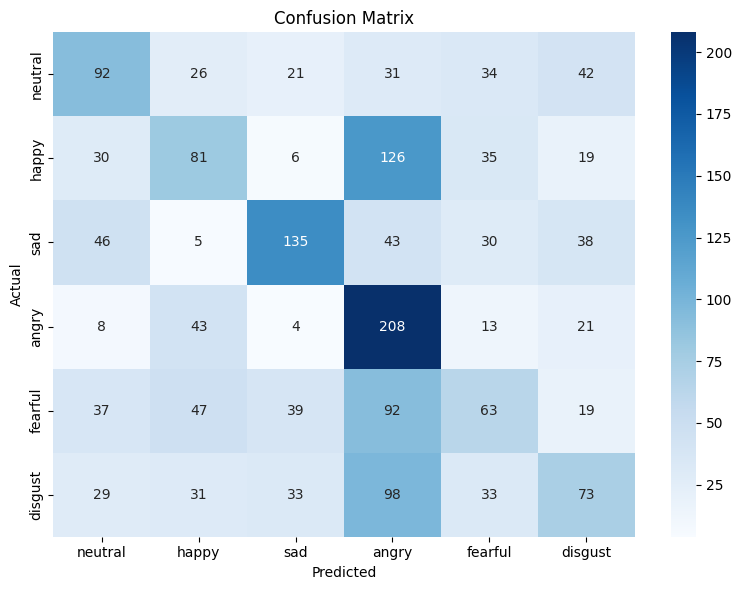

In [8]:
# Create data loaders for topological features
if 'X_train2_tensor' in locals():
    train_dataset_topo = TensorDataset(X_train2_tensor, y_train_tensor)
    val_dataset_topo = TensorDataset(X_val2_tensor, y_val_tensor)
    test_dataset_topo = TensorDataset(X_test2_tensor, y_test_tensor)

    train_loader_topo = DataLoader(train_dataset_topo, batch_size=256, shuffle=True)
    val_loader_topo = DataLoader(val_dataset_topo, batch_size=256)
    test_loader_topo = DataLoader(test_dataset_topo, batch_size=256)

    # Train topological model
    print("Training Topological Feature Model...\n")
    model_topo = TopologicalCNN().to(device)
    model_topo, history_topo = train_model(
        model_topo, train_loader_topo, val_loader_topo,
        num_epochs=40, model_name="model_topo", device=device
    )

    # Evaluate
    print("\n" + "="*60)
    print("Topological Feature Model Evaluation")
    print("="*60)
    results_topo = evaluate_model(model_topo, test_loader_topo, "best_model_topo.pth", device)

Training Combined Fusion Model...

Epoch 1/60 - train_loss: 1.7038 - val_loss: 1.6705 - val_auc: 0.6809 - val_top3: 0.6577 - val_acc: 0.2787
✅ Saved best model: 0.2787
Epoch 2/60 - train_loss: 1.3397 - val_loss: 1.6147 - val_auc: 0.7246 - val_top3: 0.7468 - val_acc: 0.3524
✅ Saved best model: 0.3524
Epoch 3/60 - train_loss: 1.1540 - val_loss: 1.6610 - val_auc: 0.7305 - val_top3: 0.7110 - val_acc: 0.3090
Epoch 4/60 - train_loss: 1.0348 - val_loss: 1.6626 - val_auc: 0.7526 - val_top3: 0.7891 - val_acc: 0.3752
✅ Saved best model: 0.3752
Epoch 5/60 - train_loss: 0.9727 - val_loss: 4.0822 - val_auc: 0.6554 - val_top3: 0.5044 - val_acc: 0.1856
Epoch 6/60 - train_loss: 0.9262 - val_loss: 1.6240 - val_auc: 0.7730 - val_top3: 0.7886 - val_acc: 0.3821
✅ Saved best model: 0.3821
Epoch 7/60 - train_loss: 0.8851 - val_loss: 1.6385 - val_auc: 0.7789 - val_top3: 0.7850 - val_acc: 0.4038
✅ Saved best model: 0.4038
Epoch 8/60 - train_loss: 0.8583 - val_loss: 1.7525 - val_auc: 0.7458 - val_top3: 0.7158 

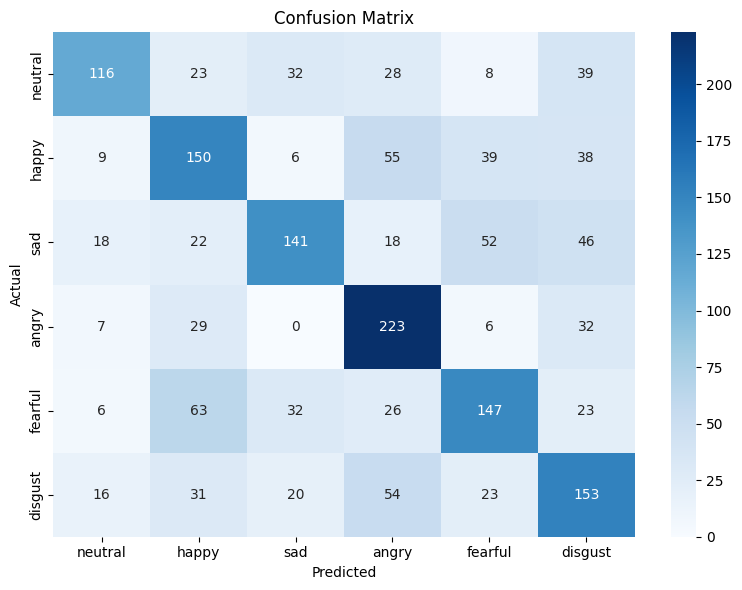

In [9]:
# Create data loaders for combined model
if 'X_train_tensor' in locals() and 'X_train2_tensor' in locals():
    train_dataset_comb = TensorDataset(X_train_tensor, X_train2_tensor, y_train_tensor)
    val_dataset_comb = TensorDataset(X_val_tensor, X_val2_tensor, y_val_tensor)
    test_dataset_comb = TensorDataset(X_test_tensor, X_test2_tensor, y_test_tensor)

    train_loader_comb = DataLoader(train_dataset_comb, batch_size=256, shuffle=True,
                                    num_workers=4, pin_memory=True)
    val_loader_comb = DataLoader(val_dataset_comb, batch_size=256,
                                  num_workers=4, pin_memory=True)
    test_loader_comb = DataLoader(test_dataset_comb, batch_size=256)

    # Train combined model
    print("Training Combined Fusion Model...\n")
    model_comb = CombinedFusionModel().to(device)
    model_comb, history_comb = train_model(
        model_comb, train_loader_comb, val_loader_comb,
        num_epochs=60, model_name="model_combined", device=device
    )

    # Evaluate
    print("\n" + "="*60)
    print("Combined Fusion Model Evaluation")
    print("="*60)
    results_comb = evaluate_model(model_comb, test_loader_comb, "best_model_combined.pth", device)


Interpretability Analysis: Integrated Gradients

Per-Channel Importance (Integrated Gradients):
Channel 0 (Euclidean (H0)): 0.000153
Channel 1 (Euclidean (H1)): 0.000089
Channel 2 (Temporal (H0)): 0.009406
Channel 3 (Temporal (H1)): 0.003675
Channel 4 (Wasserstein (H0)): 0.007251
Channel 5 (Wasserstein (H1)): 0.001776


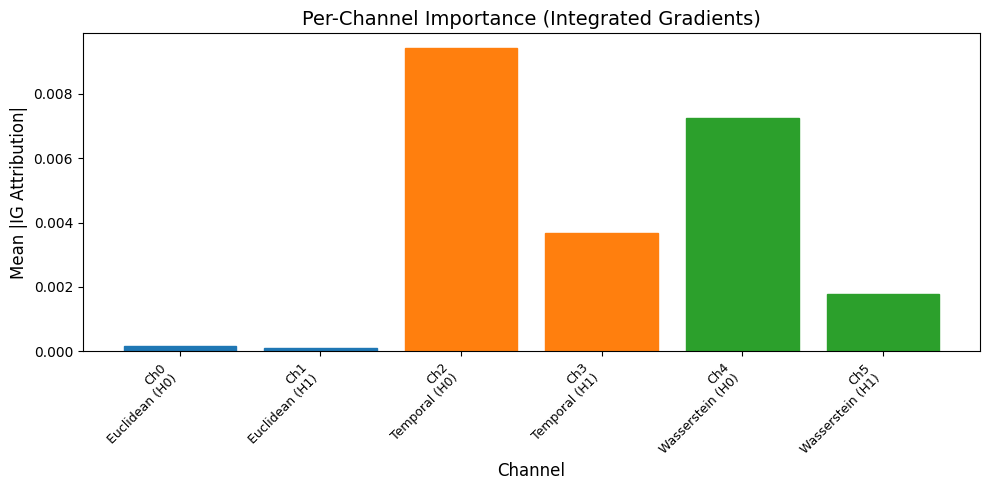

In [15]:
# Interpretability: Integrated Gradients per Channel
from pathlib import Path

def compute_channel_importance_ig(model, test_loader, device, save_dir="attr_summary"):
    """
    Compute per-channel attribution using Integrated Gradients.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    ig = IntegratedGradients(model)
    model.eval()

    acc_global = None
    count_global = 0

    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        baseline = torch.zeros_like(X_batch)

        # Compute IG
        attr = ig.attribute(X_batch, baselines=baseline, target=y_batch)
        batch_attr = attr.abs().sum(dim=0).detach().cpu()  # (C, H, W)

        acc_global = batch_attr if acc_global is None else acc_global + batch_attr
        count_global += X_batch.size(0)

    mean_attr_global = acc_global / max(count_global, 1)
    C, H, W = mean_attr_global.shape

    # Per-channel importance scores
    per_channel_scores = mean_attr_global.view(C, -1).mean(dim=1).numpy()

    print("\nPer-Channel Importance (Integrated Gradients):")
    channel_names = [
        'Euclidean (H0)',
        'Euclidean (H1)',
        'Temporal (H0)',
        'Temporal (H1)',
        'Wasserstein (H0)',
        'Wasserstein (H1)'
    ]
    for c, (name, score) in enumerate(zip(channel_names, per_channel_scores)):
        print(f"Channel {c} ({name}): {score:.6f}")

    # Save heatmaps
    def save_heat(heat2d, title, path):
        h = (heat2d - heat2d.min()) / (heat2d.max() - heat2d.min() + 1e-8)
        plt.figure(figsize=(4.5, 4))
        plt.imshow(h, cmap="jet")
        plt.title(title)
        plt.axis("off")
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(path, dpi=300, bbox_inches='tight')
        plt.close()

    for c in range(C):
        heat = mean_attr_global[c].numpy()
        save_heat(heat, f"IG Attribution — {channel_names[c]}",
                  save_dir / f"ig_channel_{c}.png")

    # Bar chart
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(C), per_channel_scores)
    plt.xlabel("Channel", fontsize=12)
    plt.ylabel("Mean |IG Attribution|", fontsize=12)
    plt.title("Per-Channel Importance (Integrated Gradients)", fontsize=14)
    plt.xticks(range(C), [f"Ch{c}\n{name}" for c, name in enumerate(channel_names)],
               rotation=45, ha='right', fontsize=9)

    # Color bars by metric type
    colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c']
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.tight_layout()
    plt.savefig(save_dir / "channel_importance_ig.png", dpi=300, bbox_inches='tight')
    plt.show()

    np.save(save_dir / "per_channel_scores_ig.npy", per_channel_scores)
    return per_channel_scores


# Run IG analysis on topological model
if 'model_topo' in locals() and 'test_loader_topo' in locals():
    print("\n" + "="*60)
    print("Interpretability Analysis: Integrated Gradients")
    print("="*60)
    model_topo.load_state_dict(torch.load("best_model_topo.pth"))
    channel_scores_ig = compute_channel_importance_ig(model_topo, test_loader_topo, device)

### 5.3 Occlusion-based Attribution

---

In [16]:
# Occlusion analysis per channel
def compute_channel_importance_occlusion(model, test_loader, device,
                                         patch_size=8, stride=4,
                                         save_dir="attr_summary"):
    """
    Compute per-channel importance using Occlusion method.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    occ = Occlusion(model)
    model.eval()

    # Sample a few examples for visualization
    X_sample, y_sample = next(iter(test_loader))
    X_sample = X_sample[:5].to(device)  # First 5 samples
    y_sample = y_sample[:5].to(device)

    channel_names = [
        'Euclidean (clean)',
        'Euclidean (noise)',
        'Temporal (clean)',
        'Temporal (noise)',
        'Wasserstein (clean)',
        'Wasserstein (noise)'
    ]

    C = X_sample.shape[1]
    attr_per_channel = []

    for sample_idx in range(len(X_sample)):
        x = X_sample[sample_idx:sample_idx+1]
        target = int(y_sample[sample_idx])

        for c in range(C):
            attr = occ.attribute(
                x,
                target=target,
                sliding_window_shapes=(1, patch_size, patch_size),
                strides=(1, stride, stride),
                baselines=0
            )
            # Extract channel c attribution
            heat = attr[:, c:c+1, :, :].abs().mean(dim=1)[0].detach().cpu().numpy()
            attr_per_channel.append(heat)

            # Save individual sample heatmap
            plt.figure(figsize=(5, 4))
            plt.imshow(heat, cmap='jet')
            plt.title(f"Sample {sample_idx} - {channel_names[c]}")
            plt.colorbar()
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(save_dir / f"occ_sample{sample_idx}_ch{c}.png", dpi=150)
            plt.close()

    print("\n✅ Occlusion analysis complete. Heatmaps saved to", save_dir)
    return attr_per_channel


# Run Occlusion analysis
if 'model_topo' in locals() and 'test_loader_topo' in locals():
    print("\n" + "="*60)
    print("Interpretability Analysis: Occlusion")
    print("="*60)
    model_topo.load_state_dict(torch.load("best_model_topo.pth"))
    occlusion_attrs = compute_channel_importance_occlusion(
        model_topo, test_loader_topo, device, patch_size=8, stride=4
    )


Interpretability Analysis: Occlusion

✅ Occlusion analysis complete. Heatmaps saved to attr_summary



Embedding Visualization
Computing UMAP projection...


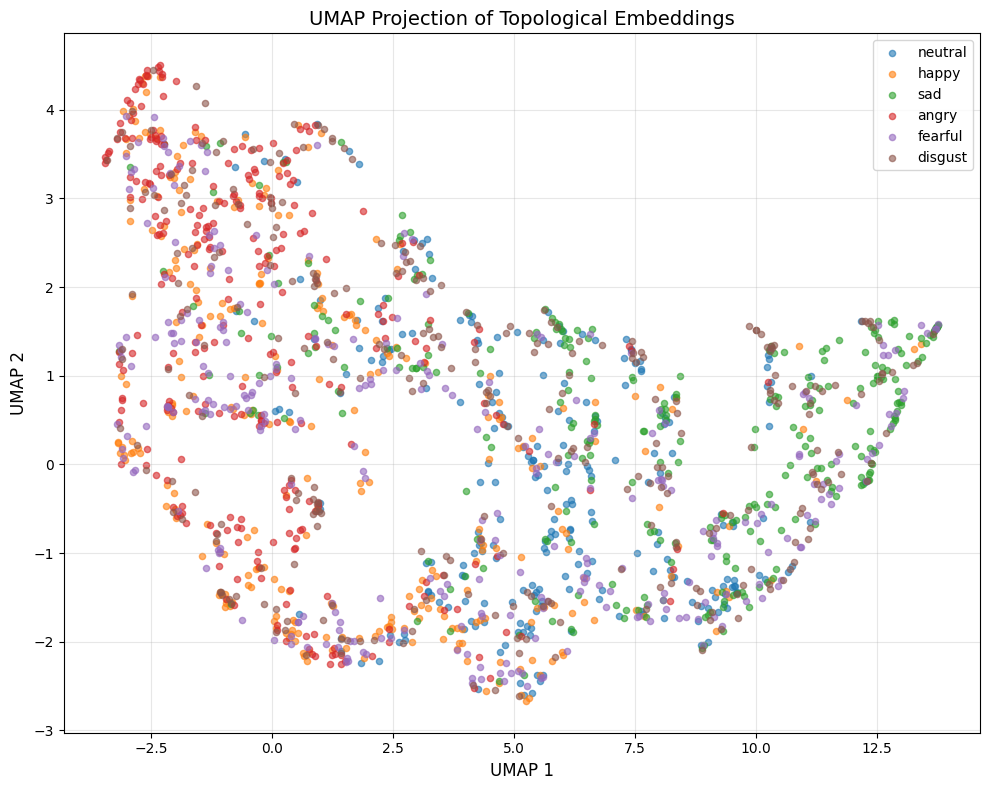


✅ Embedding visualization saved: embedding_umap.png


In [17]:
# Extract and visualize embeddings
def visualize_embeddings(model, test_loader, device):
    """
    Extract 64-dim embeddings and project to 2D using UMAP.
    """
    import umap.umap_ as umap

    model.eval()
    embs, labs = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            z = model(X_batch, return_embedding=True)  # (B, 64)
            embs.append(z.cpu().numpy())
            labs.append(y_batch.numpy())

    X_emb = np.concatenate(embs, axis=0)
    y_emb = np.concatenate(labs, axis=0)

    # UMAP projection
    print("Computing UMAP projection...")
    X_2d = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(X_emb)

    # Plot
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    plt.figure(figsize=(10, 8))
    for c, (name, color) in enumerate(zip(emotions, colors)):
        mask = (y_emb == c)
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=20, alpha=0.6,
                    label=name, color=color)

    plt.title("UMAP Projection of Topological Embeddings", fontsize=14)
    plt.xlabel("UMAP 1", fontsize=12)
    plt.ylabel("UMAP 2", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('embedding_umap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Embedding visualization saved: embedding_umap.png")
    return X_2d, y_emb


# Visualize topological embeddings
if 'model_topo' in locals() and 'test_loader_topo' in locals():
    print("\n" + "="*60)
    print("Embedding Visualization")
    print("="*60)
    model_topo.load_state_dict(torch.load("best_model_topo.pth"))
    X_2d, y_2d = visualize_embeddings(model_topo, test_loader_topo, device)

In [18]:
# Flexible Topological CNN for ablation studies
class FlexibleTopologicalCNN(nn.Module):
    """CNN that accepts variable number of topological channels."""
    def __init__(self, num_channels=6, num_classes=6):
        super(FlexibleTopologicalCNN, self).__init__()
        self.num_channels = num_channels
        self.features = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def train_ablation_model(X_train, X_val, X_test, y_train, y_val, y_test,
                         channel_indices, model_name, device,
                         num_epochs=30, lr=1e-3, verbose=False):
    """
    Train a model with specific channel subset.

    Args:
        X_train, X_val, X_test: Full topological feature tensors (B, 6, H, W)
        y_train, y_val, y_test: Label tensors
        channel_indices: List of channel indices to use
        model_name: Name for saving the model
        device: Training device
        num_epochs: Number of training epochs
        lr: Learning rate
        verbose: Print training progress

    Returns:
        Dict with test metrics
    """
    # Select specified channels
    X_train_sub = X_train[:, channel_indices, :, :]
    X_val_sub = X_val[:, channel_indices, :, :]
    X_test_sub = X_test[:, channel_indices, :, :]

    # Create data loaders
    train_dataset = TensorDataset(X_train_sub, y_train)
    val_dataset = TensorDataset(X_val_sub, y_val)
    test_dataset = TensorDataset(X_test_sub, y_test)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256)
    test_loader = DataLoader(test_dataset, batch_size=256)

    # Initialize model
    model = FlexibleTopologicalCNN(num_channels=len(channel_indices)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)

    best_val_auc = 0.0
    best_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.softmax(outputs, dim=1)
                val_preds.append(preds)
                val_labels.append(y_batch)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)
        val_auc = auroc(val_preds, val_labels).item()

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_state = model.state_dict().copy()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f}")

    # Test with best model
    model.load_state_dict(best_state)
    model.eval()

    test_preds, test_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.softmax(outputs, dim=1)
            test_preds.append(preds)
            test_labels.append(y_batch)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_auc = auroc(test_preds, test_labels).item()
    test_acc = (torch.argmax(test_preds, dim=1) == test_labels).float().mean().item()

    return {
        'auc': test_auc,
        'acc': test_acc,
        'val_auc': best_val_auc
    }


print("✅ Ablation training functions defined")

✅ Ablation training functions defined


In [14]:
# Run ablation experiments
if 'X_train2_tensor' in locals():
    print("="*60)
    print("Running Ablation Study")
    print("="*60)

    # Define ablation configurations
    ablation_configs = {
        # Baseline
        'All 6 channels': [0, 1, 2, 3, 4, 5],

        # Individual channels
        'Euclidean H0': [0],
        'Euclidean H1': [1],
        'Temporal H0': [2],
        'Temporal H1': [3],
        'Wasserstein H0': [4],
        'Wasserstein H1': [5],

        # Metric groups
        'Euclidean only': [0, 1],
        'Temporal only': [2, 3],
        'Wasserstein only': [4, 5],

        # Leave-one-out (remove metric groups)
        'Without Euclidean': [2, 3, 4, 5],
        'Without Temporal': [0, 1, 4, 5],
        'Without Wasserstein': [0, 1, 2, 3],
    }

    ablation_results = {}

    for config_name, channels in ablation_configs.items():
        print(f"\n{config_name} (channels {channels})...")

        results = train_ablation_model(
            X_train2_tensor, X_val2_tensor, X_test2_tensor,
            y_train_tensor, y_val_tensor, y_test_tensor,
            channel_indices=channels,
            model_name=f"ablation_{config_name.replace(' ', '_')}",
            device=device,
            num_epochs=30,
            lr=1e-3,
            verbose=False
        )

        ablation_results[config_name] = results
        print(f"  ✅ Test AUC: {results['auc']:.4f} | Test Acc: {results['acc']:.4f}")

    print("\n" + "="*60)
    print("Ablation Study Complete!")
    print("="*60)
else:
    print("⚠️ Training data not available. Please run previous cells first.")

Running Ablation Study

All 6 channels (channels [0, 1, 2, 3, 4, 5])...
  ✅ Test AUC: 0.7371 | Test Acc: 0.3593

Euclidean H0 (channels [0])...
  ✅ Test AUC: 0.6977 | Test Acc: 0.3328

Euclidean H1 (channels [1])...
  ✅ Test AUC: 0.6509 | Test Acc: 0.2629

Temporal H0 (channels [2])...
  ✅ Test AUC: 0.6959 | Test Acc: 0.3322

Temporal H1 (channels [3])...
  ✅ Test AUC: 0.6694 | Test Acc: 0.2981

Wasserstein H0 (channels [4])...
  ✅ Test AUC: 0.7003 | Test Acc: 0.3304

Wasserstein H1 (channels [5])...
  ✅ Test AUC: 0.6524 | Test Acc: 0.3079

Euclidean only (channels [0, 1])...
  ✅ Test AUC: 0.7111 | Test Acc: 0.3570

Temporal only (channels [2, 3])...
  ✅ Test AUC: 0.7164 | Test Acc: 0.3507

Wasserstein only (channels [4, 5])...
  ✅ Test AUC: 0.7059 | Test Acc: 0.3484

Without Euclidean (channels [2, 3, 4, 5])...
  ✅ Test AUC: 0.7304 | Test Acc: 0.3663

Without Temporal (channels [0, 1, 4, 5])...
  ✅ Test AUC: 0.7223 | Test Acc: 0.3351

Without Wasserstein (channels [0, 1, 2, 3])...
  ✅